In [15]:

import matplotlib
from matplotlib import pyplot as plt
from ren import renAlgo
import scipy
import scipy.signal
import numpy as np
import os
from calibrate import focal2distance
import pickle
import cv2
from huHann import huHann
import time

In [16]:
class Timer(object):
    def __init__(self, name=None,mute=False,stream="CLI",GObj=None):
        self.name = name
        self.mute=mute

    def __enter__(self):
        self.tstart = time.time()
        return self
    

    def __exit__(self, type, value, traceback):
        if self.name and not self.mute:
            print ('[%s]' % self.name,)
            print ('Elapsed: %s' % (time.time() - self.tstart))
    def lapse(self):
        return time.time() - self.tstart
    def toc(self,handle):
        if not self.mute:
            print("T+:%.6f ; @ %s" % (self.lapse(),handle))
        return self.lapse

In [19]:
def neighbourReplace(src,size):
    Rf=scipy.ndimage.maximum_filter(src,size=size)
    src[np.where(src<=0.49)]= Rf[np.where(src<=0.49)]
    return src

def renAlgo(files,focal):
    confMaps=[]
    with Timer("time this",mute=False) as tic:
        for index, filename in enumerate(files):
            print(filename)

            im = cv2.imread(filename)
            tic.toc("read files")
            img=im[:,:,2].astype(int)
            blurmap=huHann(img)
            #plt.figure()
            #plt.imshow(blurmap,cmap="gray")
            tic.toc("huhanned")
            nmap=(8-blurmap)/8
            tic.toc("normalized")
            #plt.figure()
            #plt.imshow(nmap,cmap="gray")
            blur = cv2.GaussianBlur(nmap,(99,99),0)
            blur = cv2.GaussianBlur(blur,(99,99),0) # second order
            tic.toc("blurred")
            #plt.figure()
            #plt.imshow(blur,cmap="gray")
            confMaps.append(blur)
        tic.toc("DONE PREP")

        flatConf=np.array(confMaps)
        

        oneDepth=np.ones([len(flatConf[0,:,0]),len(flatConf[0,0,:])])
        for row in range(len(flatConf[0,:,0])):
            for col in range(len(flatConf[0,0,:])):
                corr=flatConf[:,row,col]
                maxInd=corr.argmax()
                #print(maxInd)
                oneDepth[row,col]=focal[maxInd]
        tic.toc("done stashing")
        #plt.figure()
        #plt.imshow(oneDepth,cmap="gray")
        result=255*(neighbourReplace(oneDepth,100)-min(focal))/(max(focal)-min(focal))
        tic.toc("neighbouted ran")
        #plt.figure()
        #plt.imshow(result,cmap="gray")
    # and renormalize
    return result


[0.4, 0.55, 0.7, 0.72, 0.75, 0.77, 0.8, 0.85]
8
8
testset2/IMG_8494.JPG
T+:0.270909 ; @ read files
T+:2.139214 ; @ huhanned
T+:2.188894 ; @ normalized
T+:5.686545 ; @ blurred
testset2/IMG_8495.JPG
T+:5.944972 ; @ read files
T+:7.881536 ; @ huhanned
T+:7.937474 ; @ normalized
T+:12.217686 ; @ blurred
testset2/IMG_8496.JPG
T+:12.484337 ; @ read files
T+:14.160159 ; @ huhanned
T+:14.219622 ; @ normalized
T+:17.827509 ; @ blurred
testset2/IMG_8497.JPG
T+:18.088808 ; @ read files
T+:19.900395 ; @ huhanned
T+:19.959759 ; @ normalized
T+:23.658090 ; @ blurred
testset2/IMG_8498.JPG
T+:23.913027 ; @ read files
T+:25.759295 ; @ huhanned
T+:25.817623 ; @ normalized
T+:29.576933 ; @ blurred
testset2/IMG_8499.JPG
T+:29.884727 ; @ read files
T+:31.670284 ; @ huhanned
T+:31.729599 ; @ normalized
T+:35.386062 ; @ blurred
testset2/IMG_8500.JPG
T+:35.638554 ; @ read files
T+:37.312537 ; @ huhanned
T+:37.369410 ; @ normalized
T+:40.861119 ; @ blurred
testset2/IMG_8501.JPG
T+:41.112717 ; @ read files
T+:4

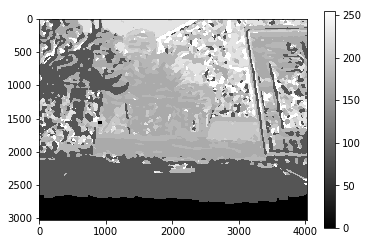

In [20]:
focal=[0.4, 0.55, 0.7, 0.72, 0.75, 0.77, 0.8, 0.85]
#focal=[focal2distance(x) for x in focal]
print(focal)
filesDir=[]
for file in os.listdir("testset2"):
    
    filesDir.append("testset2/"+file)

print(len(focal))
print(len(filesDir))

smoothDepth=renAlgo(filesDir,focal)


plt.imshow(smoothDepth,cmap='gray')
plt.colorbar()

plt.imsave("newmap2.png",smoothDepth,cmap='gray')
